<a href="https://colab.research.google.com/github/ellenguyen/CIS4496_EY/blob/main/model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1

## Connect to T4 GPU

#### Install

In [11]:
%pip install ultralytics
!pip install opencv-python-headless
!pip install labelme2yolo
!pip install rasterio

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)



  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


#### Import Libraries

In [12]:
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
import labelme2yolo

# Others
import os
import shutil
import zipfile
import re
import subprocess
import shutil

%matplotlib inline

In [13]:
# # Import images if not done already

os.makedirs('given', exist_ok = True)
os.makedirs('generated_data', exist_ok = True )

!wget https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif -O given/Post_Event_San_Juan.tif
!wget https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif -O given/Pre_Event_San_Juan.tif

--2024-02-28 03:17:01--  https://challenge.ey.com/api/v1/storage/admin-files/Post_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310494499 (1.2G) [application/octet-stream]
Saving to: ‘given/Post_Event_San_Juan.tif’

given/Post_Event_Sa 100%[===================>]   1.22G  18.6MB/s    in 68s     

2024-02-28 03:18:21 (18.4 MB/s) - ‘given/Post_Event_San_Juan.tif’ saved [1310494499/1310494499]

--2024-02-28 03:18:21--  https://challenge.ey.com/api/v1/storage/admin-files/Pre_Event_San_Juan.tif
Resolving challenge.ey.com (challenge.ey.com)... 52.236.158.32
Connecting to challenge.ey.com (challenge.ey.com)|52.236.158.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1016993213 (970M) [application/octet-stream]
Saving to: ‘given/Pre_Event_San_Juan.tif’

given/Pre_Event_San 100%[=================

In [14]:
import rasterio
from rasterio import windows
import os
import numpy as np
import random

def generate_random_tiles(src_path, dst_folder, random_windows, label):
    """
    Generate tiles from a GeoTIFF image using predefined windows and label them accordingly.
    """
    with rasterio.open(src_path) as src:
        out_meta = src.meta.copy()

        for count, window in enumerate(random_windows):
            img = src.read(window=window)
            if np.any(img):
                out_meta.update({
                    "driver": "GTiff",
                    "height": window.height,
                    "width": window.width,
                    "transform": rasterio.windows.transform(window, src.transform)
                })
                # Incorporate the label into the filename
                out_path = os.path.join(dst_folder, f"{label}_random_tile_{count}.tif")
                with rasterio.open(out_path, 'w', **out_meta) as out_dst:
                    out_dst.write(img)

def create_random_windows(width, height, tile_width, tile_height, max_tiles):
    """
    Generate a list of random windows for tile extraction.
    """
    random_windows = []
    for _ in range(max_tiles):
        rand_x = random.randint(0, width - tile_width)
        rand_y = random.randint(0, height - tile_height)
        window = windows.Window(rand_x, rand_y, tile_width, tile_height)
        random_windows.append(window)
    return random_windows

def main(pre_event_path, post_event_path, tile_width, tile_height, max_tiles=10):
    """
    Main function to generate random tiles from aligned pre-event and post-event images.
    """
    pre_event_dir = 'generated_data/Pre_Event_Tiles'
    post_event_dir = 'generated_data/Post_Event_Tiles'

    os.makedirs(pre_event_dir, exist_ok=True)
    os.makedirs(post_event_dir, exist_ok=True)

    # Open one of the images to determine dimensions for window generation
    with rasterio.open(pre_event_path) as src:
        width, height = src.width, src.height

    # Generate random windows
    random_windows = create_random_windows(width, height, tile_width, tile_height, max_tiles)

    # Generate tiles using the same set of random windows for both images, with appropriate labeling
    generate_random_tiles(pre_event_path, pre_event_dir, random_windows, "pre")
    generate_random_tiles(post_event_path, post_event_dir, random_windows, "post")

    print("Random tile generation completed for both pre-event and post-event images.")

if __name__ == "__main__":

    pre_event_path = 'given/Pre_Event_San_Juan.tif'
    post_event_path = 'given/Post_Event_San_Juan.tif'
    tile_width, tile_height = 512, 512  # Adjust as needed

    main(pre_event_path, post_event_path, tile_width, tile_height)


Random tile generation completed for both pre-event and post-event images.


In [15]:
from PIL import Image
import os

def convert_tiff_to_jpeg(input_folder, output_folder):
    """
    Convert all TIFF images in the input_folder to JPEG format and save them in the output_folder.
    """
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all TIFF files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            # Construct the full file path
            input_path = os.path.join(input_folder, filename)
            # Define the output file path with a .jpg extension
            output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.jpg')

            # Open the TIFF image, convert to RGB (in case it's not), and save as JPEG
            with Image.open(input_path) as img:
                rgb_img = img.convert('RGB')
                rgb_img.save(output_path, 'JPEG')

    print(f"Conversion completed. JPEG images are saved in {output_folder}.")

# Repeat for post-event tiles if necessary
input_folder_post = 'generated_data/Post_Event_Tiles'  # Adjust to your actual input folder path
output_folder_post = 'generated_data/Post_Event_Tiles_JPEG'  # Adjust to your desired output folder path
convert_tiff_to_jpeg(input_folder_post, output_folder_post)


Conversion completed. JPEG images are saved in generated_data/Post_Event_Tiles_JPEG.


In [ ]:
import rasterio
from rasterio.windows import Window
import os

def crop_tiles_to_square(src_folder, dst_folder):
    """
    Crop all TIFF tiles in the source folder to square dimensions, maximizing the size of the image,
    and save them to the destination folder.
    """
    os.makedirs(dst_folder, exist_ok=True)  # Create destination folder if it doesn't exist

    for tile_filename in os.listdir(src_folder):
        if tile_filename.endswith('.tif') or tile_filename.endswith('.tiff'):
            src_path = os.path.join(src_folder, tile_filename)
            dst_path = os.path.join(dst_folder, tile_filename)

            with rasterio.open(src_path) as src:
                # Determine the minimum dimension to make the image square
                min_dim = min(src.width, src.height)
                # Calculate offsets for centering the crop
                off_x = (src.width - min_dim) // 2
                off_y = (src.height - min_dim) // 2

                # Define the window to crop the square area
                window = Window(off_x, off_y, min_dim, min_dim)
                window_transform = src.window_transform(window)

                # Read the data from the window
                data = src.read(window=window)

                # Update metadata for the output image
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": min_dim,
                    "width": min_dim,
                    "transform": window_transform
                })

                # Write the cropped square image
                with rasterio.open(dst_path, 'w', **out_meta) as dst:
                    dst.write(data)

    print("All tiles have been cropped to square dimensions and saved to the destination folder.")

# Example usage
src_folder = 'generated_data/Pre_Event_Tiles'  # Adjust to your actual source directory of tiles
dst_folder = 'generated_data/Pre_Event_Tiles_Square'  # Desired destination directory for square tiles
crop_tiles_to_square(src_folder, dst_folder)

# Repeat for post-event tiles if necessary
src_folder_post = 'generated_data/Post_Event_Tiles'  # Adjust to your actual source directory of tiles
dst_folder_post = 'generated_data/Post_Event_Tiles_Square'  # Desired destination directory for square tiles
crop_tiles_to_square(src_folder_post, dst_folder_post)


All tiles have been cropped to square dimensions and saved to the destination folder.
All tiles have been cropped to square dimensions and saved to the destination folder.


In [16]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from PIL import Image
import cv2
import matplotlib.pyplot as plt

# Check if GPU is available
torch.cuda.is_available()


True

In [37]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # Set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda"  # Use CUDA for GPU acceleration

predictor = DefaultPredictor(cfg)


[02/28 03:44:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


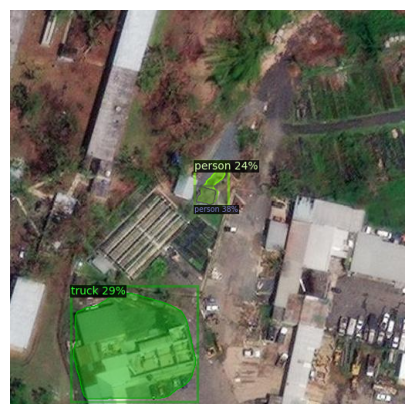

In [38]:
def detect_buildings(tile_path):
    im = cv2.imread(tile_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    outputs = predictor(im)

    # Extracting the image shape for visualization scaling
    height, width, _ = im.shape

    # Visualize the prediction results
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(width / 100, height / 100), dpi=100)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')  # Remove axes ticks
    plt.show()



# Example usage
tile_path = 'generated_data/Post_Event_Tiles_JPEG/post_random_tile_1.jpg'  # Adjust the path to your tile
detect_buildings(tile_path)
